## 1. Why NLP Here? (Framing)

The objective of this notebook is to apply Natural Language Processing (NLP) techniques to video transcripts in order to extract contextual, semantic, and narrative insights.
Unlike exploratory statistics, this analysis focuses on meaning, intent, emotional framing, and topic structure, enabling scalable content intelligence across playlists.

## 2. NLP Stack (Simple, Explainable, Professional)

We will use:

| Task                | Method                    | Why                             |
| ------------------- | ------------------------- | ------------------------------- |
| Cleaning            | spaCy / regex             | Industry standard               |
| Tokenization & POS  | spaCy                     | Context-aware                   |
| Sentiment           | VADER                     | Optimized for social/media text |
| Topics              | LDA / BERTopic (optional) | Semantic clustering             |
| Keywords            | TF-IDF                    | Interpretable                   |
| Semantic similarity | Sentence embeddings       | Narrative grouping              |


## 3. Data Loading & Preprocessing

In [8]:
import pandas as pd
import spacy
import re

nlp = spacy.load("en_core_web_sm")

df_videos = pd.read_csv("../data/raw/videos/only_1_minute_videos.csv")
df_transcripts = pd.read_csv("../data/raw/transcripts/only_1_minute_manual.csv")

df = df_videos.merge(df_transcripts, on="video_id", how="inner")
df["transcript"] = df["transcript"].astype(str)


### Cleaning function

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

df["clean_transcript"] = df["transcript"].apply(clean_text)


## 4. Linguistic Context Analysis (spaCy)
### 4.1 POS Distribution (Narrative Style)

In [10]:
def pos_distribution(text):
    doc = nlp(text)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    return pos_counts

pos_df = df["clean_transcript"].apply(pos_distribution).apply(pd.Series).fillna(0)
df = pd.concat([df, pos_df], axis=1)


## 5. Sentiment & Emotional Polarity (VADER)
### 5.1 Sentiment Scoring

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

df["sentiment_score"] = df["clean_transcript"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...


In [14]:
df["engagement_rate"] = (
    df["likes"] + df["comments"]
) / df["views"]


In [15]:
df[["sentiment_score", "engagement_rate"]].corr()


,sentiment_score,engagement_rate
sentiment_score,1.000000,0.011531
engagement_rate,0.011531,1.000000


## 6. Keyword & Theme Extraction (TF-IDF)
### 6.1 TF-IDF Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=500
)

tfidf_matrix = tfidf.fit_transform(df["clean_transcript"])


In [17]:
feature_names = tfidf.get_feature_names_out()

def top_keywords(row, n=5):
    indices = row.toarray()[0].argsort()[-n:]
    return [feature_names[i] for i in indices]

df["top_keywords"] = [
    top_keywords(tfidf_matrix[i])
    for i in range(tfidf_matrix.shape[0])
]


## 7. Topic Modeling (Semantic Context)
### Option A (Classical & Defensible): LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)

topics = lda.fit_transform(tfidf_matrix)
df["dominant_topic"] = topics.argmax(axis=1)


In [19]:
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:",
          [feature_names[i] for i in topic.argsort()[-7:]])


Topic 0: ['wasnt', 'person', 'english', 'use', 'video', 'games', 'languages']
Topic 1: ['like', 'im', 'thats', 'world', 'people', 'just', 'country']
Topic 2: ['boring', 'science', 'parents', 'voice', 'greg', 'taught', 'case']
Topic 3: ['dollars', 'toilets', 'city', 'bucks', 'smoke', 'smoking', 'dollar']
Topic 4: ['het', 'voor', 'ik', 'heaven', 'er', 'muziek', 'en']


## 8. Semantic Similarity (Narrative Grouping)
### Sentence Embeddings (Lightweight)

In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["clean_transcript"].tolist())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
similarity_matrix = cosine_similarity(embeddings)

## 9. NLP-Based Context Archetypes

### Combine NLP outputs:

In [23]:
def nlp_context(row):
    if row["sentiment_score"] > 0.5:
        return "Positive Inspirational"
    if row["dominant_topic"] == 0:
        return "Educational Explainer"
    if row["sentiment_score"] < -0.2:
        return "Problem-Oriented"
    return "Neutral Narrative"

df["nlp_context_type"] = df.apply(nlp_context, axis=1)


In [24]:
df.groupby("nlp_context_type")[["views", "engagement_rate"]].mean()


,views,engagement_rate
nlp_context_type,,
Neutral Narrative,2.149764e+06,0.032811
Positive Inspirational,1.660800e+06,0.033447
Problem-Oriented,2.231335e+06,0.033526


## Graph: POS Distribution (Aggregated)

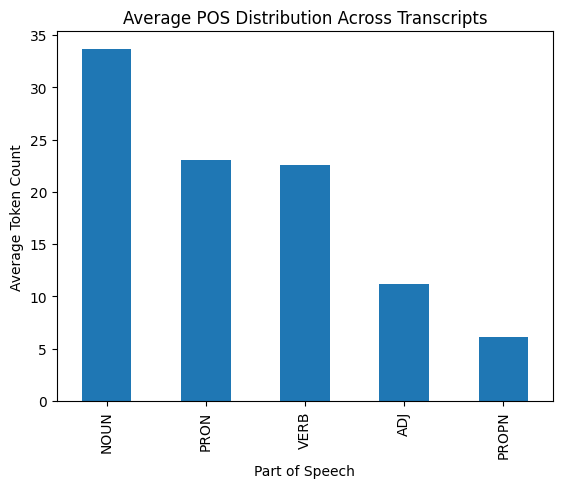

In [25]:
pos_cols = ["NOUN", "VERB", "PRON", "PROPN", "ADJ"]

pos_summary = df[pos_cols].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt

plt.figure()
pos_summary.plot(kind="bar")
plt.title("Average POS Distribution Across Transcripts")
plt.ylabel("Average Token Count")
plt.xlabel("Part of Speech")
plt.show()


## Sentiment Analysis (Emotional Polarity)
### Graph 1: Sentiment Distribution

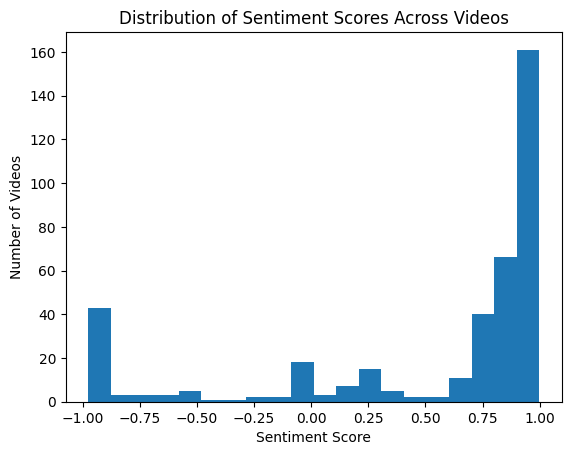

In [26]:
plt.figure()
plt.hist(df["sentiment_score"], bins=20)
plt.title("Distribution of Sentiment Scores Across Videos")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Videos")
plt.show()


### Graph 2: Sentiment vs Engagement

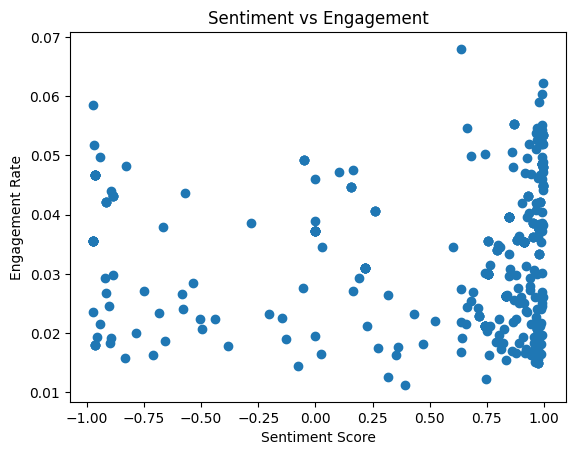

In [27]:
plt.figure()
plt.scatter(df["sentiment_score"], df["engagement_rate"])
plt.xlabel("Sentiment Score")
plt.ylabel("Engagement Rate")
plt.title("Sentiment vs Engagement")
plt.show()


## Keyword & Semantic Importance (TF-IDF)
### Graph: Top Global Keywords (TF-IDF Weight)

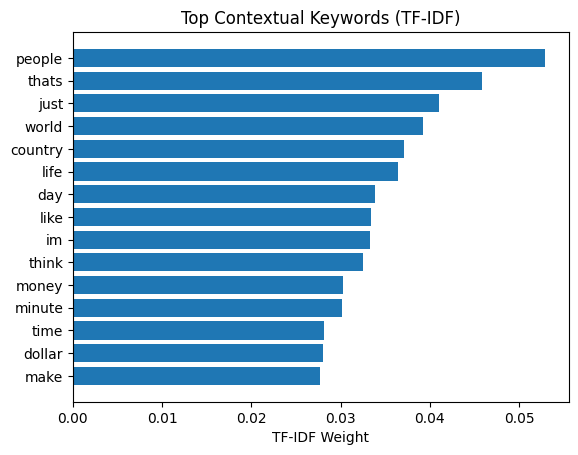

In [28]:
import numpy as np

tfidf_scores = tfidf_matrix.mean(axis=0).A1
keywords = tfidf.get_feature_names_out()

top_idx = np.argsort(tfidf_scores)[-15:]

plt.figure()
plt.barh([keywords[i] for i in top_idx], tfidf_scores[top_idx])
plt.title("Top Contextual Keywords (TF-IDF)")
plt.xlabel("TF-IDF Weight")
plt.show()


## Topic Modeling (LDA)
### Graph 1: Topic Prevalence

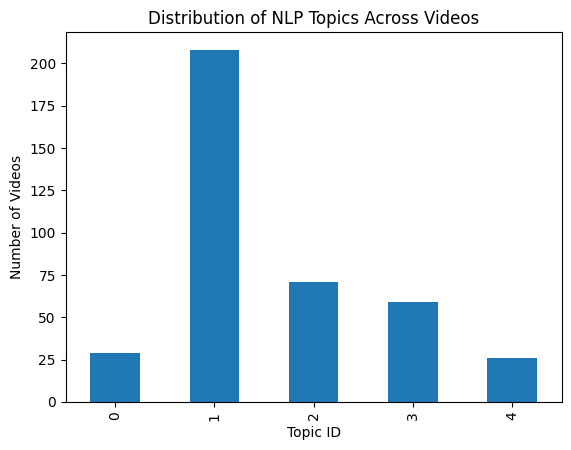

In [29]:
topic_counts = df["dominant_topic"].value_counts().sort_index()

plt.figure()
topic_counts.plot(kind="bar")
plt.xlabel("Topic ID")
plt.ylabel("Number of Videos")
plt.title("Distribution of NLP Topics Across Videos")
plt.show()


## Graph 2: Topic vs Engagement

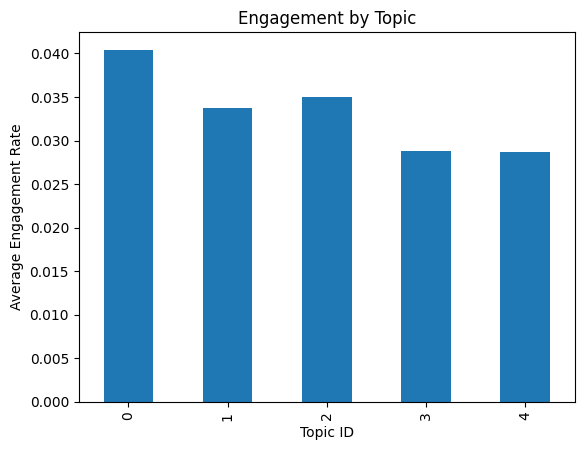

In [30]:
topic_eng = df.groupby("dominant_topic")["engagement_rate"].mean()

plt.figure()
topic_eng.plot(kind="bar")
plt.ylabel("Average Engagement Rate")
plt.xlabel("Topic ID")
plt.title("Engagement by Topic")
plt.show()


## Semantic Similarity (Narrative Redundancy)
### Graph: Similarity Heatmap (Sample)

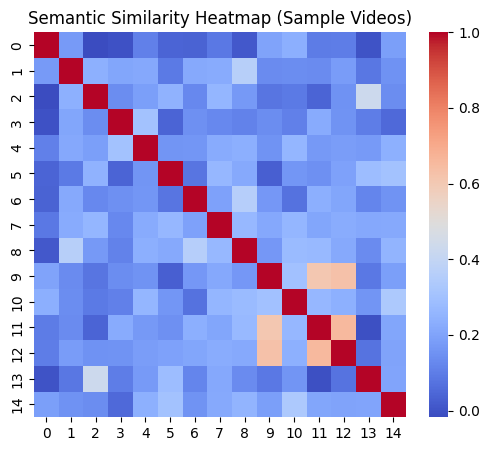

In [31]:
import seaborn as sns
import numpy as np

sample_sim = similarity_matrix[:15, :15]

plt.figure(figsize=(6,5))
sns.heatmap(sample_sim, cmap="coolwarm")
plt.title("Semantic Similarity Heatmap (Sample Videos)")
plt.show()


## NLP-Derived Context Archetypes
### Graph 1: Archetype Distribution

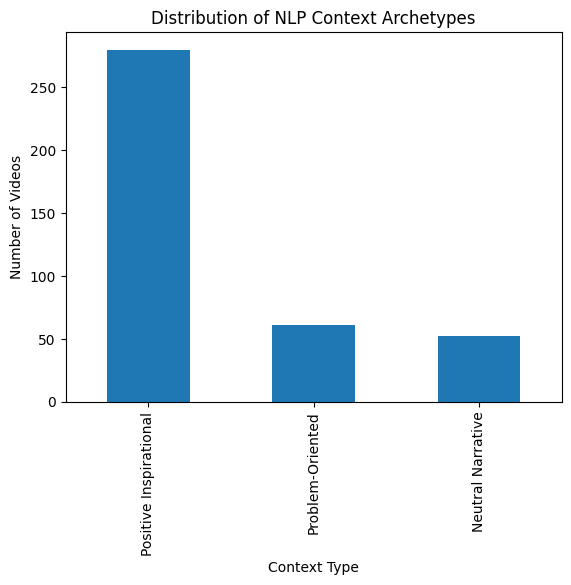

In [32]:
df["nlp_context_type"].value_counts().plot(kind="bar")
plt.title("Distribution of NLP Context Archetypes")
plt.xlabel("Context Type")
plt.ylabel("Number of Videos")
plt.show()


### Graph 2: Archetype Performance

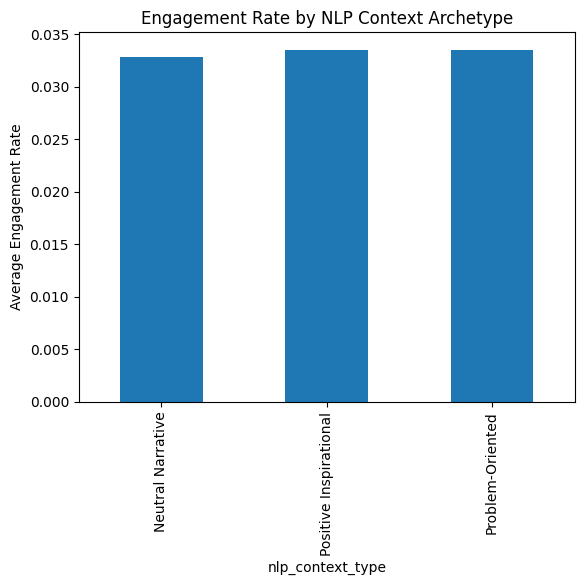

In [33]:
arch_perf = df.groupby("nlp_context_type")["engagement_rate"].mean()

plt.figure()
arch_perf.plot(kind="bar")
plt.ylabel("Average Engagement Rate")
plt.title("Engagement Rate by NLP Context Archetype")
plt.show()
